# Gray code encoding for ab initio interaction

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [48]:
def generate_relative_states(Nmax,J,L=-1):
    """
    Generate deuteron basis for J subject to antisymmetry constraints
    """
    ## For deuteron, J=1
    i=0
    labels={}
    
    Nlist=list(range(0,Nmax+1,2))
 
    
    for T in [0,1]:
        for N in Nlist:
            ## If restricted to specific L channel
            if L==-1:
                L_values=list(range(N%2,N+1,2))
            else:
                L_values=[L]
                
            for L in L_values:
                for S in [0,1]:
                
                    if (N+S+T)%2!=1:
                        continue
                    if abs(L-S)<=J and (L+S)>=J:
                        labels[(N,L,S,J,T)]=i
                        i += 1

    return labels


def get_interaction(filename,basis):
    """
    Read in interaction from file. 
    File format is given in spncci/basis/lsjt_operator.h
    """
#     basis=generate_relative_states(Nmax,J)
    dim=len(basis)
    V=np.zeros((dim,dim))
    # interaction={}
    f=open(filename,'r')
    # Skipping header lines
    for i in range(6):
        next(f)
    ## Get relevant header information 
    operator_info=f.readline()
    operator_basis_info=f.readline()
    #for each line, get labels and matrix element, look up 
    for line in f:
        labels = tuple(map(int,line.split()[:11]))
        value = float(line.split()[11])
        [T0, Np, Lp, Sp, Jp, Tp, N, L, S, J, T]=labels
        statep = (Np, Lp, Sp, Jp, Tp)
        state = (N, L, S, J, T)
        if (statep in basis) and (state in basis):
            i = basis[state]
            ip = basis[statep]
            ## Sums over T0 values if relevant 
            V[ip,i] += value
            if ip!=i:
                V[i,ip] += value

    f.close()
#     print(V)
    return V

def toy_interaction(basis):
    """
    Read in interaction from file. 
    File format is given in spncci/basis/lsjt_operator.h
    """
#     basis=generate_relative_states(Nmax,J)
    dim=len(basis)
    V=np.zeros((dim,dim))
    # Skipping header lines

    for statep in basis:
        [Np,Lp,Sp,Jp,Tp]=statep
        ip=basis[statep]
        for state in basis:
            [N,L,S,J,T]=state
            i=basis[state]
            n=(N-L)/2
            n_prime=(Np-Lp)/2
            if(n==n_prime) and (n==0) and ((L,S,J,T)==(Lp,Sp,Jp,Tp)):
                V[ip,i] = -5.68658111

    return V


def Tme(Np,Lp,Sp,Jp,Tp,N,L,S,J,T,hw):
    """
    Compute kinetic energy matrix element for given hw values
    based on formula given in prc-93-2016-044332-Binder
    """
    # Kinetic energy
    if (Sp!=S) or (Tp!=T) or (Jp!=J) or (Lp!=L):
        return 0

    n=int((N-L)/2);
    tme=0.0
    if Np==N:
        tme = hw/2*(2*n+L+1.5)
    if Np==(N-2):
        tme = -hw/2*np.sqrt(n*(n+L+0.5))
    if Np==(N+2):
        tme=-hw/2*np.sqrt((n+1)*(n+L+1.5))

    return tme

def get_kinetic_energy(basis,hw):
    #Construct kinetic eneryg matrix
    dim=len(basis) 
    T_matrix=np.zeros((dim,dim))
    for statep in basis:
        [Np,Lp,Sp,Jp,Tp]=statep
        ip=basis[statep]
        for state in basis:
            [N,L,S,J,T]=state
            i=basis[state]

            T_matrix[ip,i]=Tme(Np,Lp,Sp,Jp,Tp,N,L,S,J,T,hw)
    return T_matrix


def hamiltonian_matrix(Nmax,hw,J,interaction_filename):
    
    if interaction_filename=="toy_hamiltonian":
        basis=generate_relative_states(Nmax,J,L=0)
        V_matrix=toy_interaction(basis)
        hw=7
    else:
        basis=generate_relative_states(Nmax,J)
        V_matrix=get_interaction(interaction_filename,basis)
    
    #Construct kinetic eneryg matrix 
    T_matrix=get_kinetic_energy(basis,hw)
    
    return T_matrix+V_matrix



def graycode_operator(s1,s2):
    """
    Generates graycode operators for moving from state s1 to states s2
    """
    # Sum the strings elementwise modulo 2; summed entries which are 1 must be flipped 
    string_sum = [(int(s1[i]) + int(s2[i])) % 2 for i in range(len(s1))]
    N_qubits=len(s1)
    qubit_term=[None]*N_qubits
    for b in range(N_qubits):        
        # bit is flipped 
        if string_sum[b]==1:
            if s1[b] == '0':
                # qubit_term[b]=["X","miY"]
                qubit_term[b]="A0"
            elif s1[b] == '1':
                # qubit_term[b]=["X","iY"]
                qubit_term[b]="A1"
            else:
                print("error")
        
        ## bit is same 
        else:
            x=s1[b]
            qubit_term[b] = f"P{x}"

    expanded_sequence=expand_projector_sequence(qubit_term)

    return expanded_sequence

def expand_projector_sequence(seq):
    # Take a list of projectors, e.g. ["P0", "P1", "X"] and expand it in terms of Paulis 
    # return an openfermion QubitOperator

    # Copy the sequence before making replacements
    substitution_seq = seq

    if len(seq) <= 0:
        raise ValueError(f"Cannot expand empty projector sequence.")

#     if any([x not in mats.keys() for x in seq]):
#         raise ValueError(f"Sequence {seq} contains elements that are not Paulis or P0/P1 projectors.")  

    prefactor_count=substitution_seq.count("P0") + substitution_seq.count("P1")
    prefactor_count+=substitution_seq.count("A0")+substitution_seq.count("A1")
    prefactor = 1 / (2 ** (prefactor_count))
    # First, replace operators with expanded form 
    
    for item_idx in range(len(seq)):
        if seq[item_idx] == "P0":
            substitution_seq[item_idx] = ["I", "Z"]
        elif seq[item_idx] == "P1":
            substitution_seq[item_idx] = ["I", "mZ"]
        elif seq[item_idx] == "A0":
            substitution_seq[item_idx] = ["X", "iY"]
        elif seq[item_idx] == "A1":
            substitution_seq[item_idx] = ["X", "miY"]


    qubit_operators = []
    
    # Expand out the term into individual Paulis
    for pauli in product(*substitution_seq):
        pauli_string = "".join(pauli)
        # Extract the sign and remove the m indicators
        sign = (-1) ** pauli_string.count("m")
        pauli_string = pauli_string.replace("m", "")

        sign *= (1j)**pauli_string.count("i")
        pauli_string = pauli_string.replace("i", "")

        # Remove identities and label Paulis with their qubit indices
        qubit_operator_string = ""
        for i in range(len(pauli_string)):
            if pauli_string[i] != "I":
                qubit_idx=len(pauli_string)-1-i
                qubit_operator_string += f"{pauli_string[i]}{qubit_idx} "
        
        qubit_operators.append(QubitOperator(qubit_operator_string, sign*prefactor))

    full_operator = QubitOperator()
    for term in qubit_operators:
        full_operator += term

    return full_operator 

def qubit_operator_to_dict(H):
    """
    H (EncodingHamiltonian) : qubit Hamiltonian
    """
    pauli_dictionary={}
    pauli_terms=H.pauli_rep.terms
    for pauli_term in pauli_terms:
        pauli_string = ["I"] * H.N_qubits
        for pauli in pauli_term:
            pauli_string[pauli[0]] = pauli[1]

        # If we are using qiskit, reverse the string so that the flipped Paulis
        # will get the correct coefficients
        if H.qiskit_order:
            pauli_string = pauli_string[::-1]
        pauli_dictionary["".join(pauli_string)]=pauli_terms[pauli_term]        

    return pauli_dictionary




class EncodingHamiltonian():

    # def __init__(self, N_qubits, N_states, qiskit_order=True):
    def __init__(self, H_matrix, qiskit_order=True):
        # self.N_qubits = N_qubits
        self.N_states = np.size(H_matrix,0)
        self.ferm_rep = self._generate_ferm_rep(H_matrix)
        self.qiskit_order = qiskit_order

    def _generate_ferm_rep(self,H_matrix):
        """ Construct the Fermionic representation of this Hamiltonian"""
        
        # Initialize 
        H = FermionOperator('1^ 1', 0)

        for n, n_prime in product(range(self.N_states), repeat=2):

            H += FermionOperator(f"{n_prime+1}^ {n+1}", H_matrix[n_prime,n])

        return H
 
    
class GrayCodeHamiltonian(EncodingHamiltonian):
    def __init__(self, H, qiskit_order=True):
        """ Class for Gray code encoding that uses N qubits to represent 2^N states.  [TODO:REF]

        Parameters:
            N_states (int) : The number of harmonic oscillator states to consider. For this
                encoding, the number of qubits will be Ceiling[log2[N_states]].

            qiskit_order (bool,optional) : Determines whether to order the qubits in qiskit order, i.e.
                in "reverse" as compared to the typical ordering. Default : True.

        """
        super(GrayCodeHamiltonian, self).__init__(H, qiskit_order)

        N_states=np.size(H,0)
        N_qubits = int(np.ceil(np.log2(N_states)))

        if N_states == 1:
            N_qubits = 1

        self.N_qubits=N_qubits

        # Get the order of the states in the gray code
        self.state_order = gray_code(self.N_qubits)
        
        # Map order of states onto qiskit basis??? Liv?
        self.permutation = [int("0b" + x, 2) for x in self.state_order] 

        # Get pauli representation for H acting on qubit states ordered by gray code
        self.pauli_rep = self._build_pauli_rep(H) 
        self.to_dict=qubit_operator_to_dict(self)
        self.pauli_partitions = self._pauli_partitions()
        
        
        self.pauli_coeffs = qubit_operator_to_dict(self) ## to make work with old code 
        
        self.n_partitions = len(self.pauli_partitions.keys())
        
        self.matrix = self._to_matrix()
    
    def _build_pauli_rep(self,H):
        """
        Get pauli representation for H acting on qubit states ordered by gray code
        """
        ## Generate number of states 
        N_states=dim=np.size(H,0)
        
        ## Get number of qubits 
        N_qubits = int(np.ceil(np.log2(N_states)))
        
        ## Construct graycode for qubits 
        gc_states=gray_code(N_qubits)
        
#         print("Num states: ",N_states)
#         print("Num qubits: ",N_qubits)
#         print("gray code : ",gc_states)
#         print("")
        
        ## initialize H
        full_operator = QubitOperator()
        for ip in range(0,N_states,1):
            # for i in range(0,ip+1,1):
            for i in range(0,N_states,1):
                Hme=H[ip,i]
                if Hme == 0.0:
                    continue
                s1=gc_states[i]
                s2=gc_states[ip]
                term=graycode_operator(s1,s2)
                full_operator += Hme*term

        return full_operator 

    def _to_matrix(self):
        ## If in qiskit ordering, need to flip pauli strings to get back to left to right ordering for matrix rep
        if self.qiskit_order:
            return reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0][::-1]) for p in self.to_dict.items()]).real
        else:
            return reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in self.to_dict.items()]).real

#     def _to_dict(self):
#         """
#              : qubit Hamiltonian
#         """
#         pauli_dictionary={}
#         pauli_terms=self.pauli_rep.terms
#         for pauli_term in pauli_terms:
#             pauli_string = ["I"] * self.N_qubits
#             for pauli in pauli_term:
#                 pauli_string[pauli[0]] = pauli[1]

#             # If we are using qiskit, reverse the string so that the flipped Paulis
#             # will get the correct coefficients
#             if self.qiskit_order:
#                 pauli_string = pauli_string[::-1]
#             pauli_dictionary["".join(pauli_string)]=pauli_terms[pauli_term]        

#         return pauli_dictionary

    def _pauli_partitions(self):
        """
        Partition pauli terms in Hamiltonian into commuting sets 

        Returns:
            (dictionary) : Dictionary keyed by 
        """
        pauli_dict=self.to_dict
        commuting_sets=get_commuting_sets(list(pauli_dict.keys()))

        return commuting_sets

    def _separate_coeffs(self):
        """ Pulls out the coefficients of each Pauli and stores in a dictionary separate.
        Useful for computing the expectation value because we can look up coeffs easily.
        """
        all_paulis = {}
        for set_idx, measurement_setting in self.pauli_partitions.items():
            for pauli, coeff in measurement_setting.items():
                all_paulis[pauli] = coeff.real
        return all_paulis

In [51]:
## H is always in qiskit order (right to left)
## String form is also in that order 
## State vector results in order [00,01,10,11]
from scipy.linalg import eigh

J=1
Nmax=14
hw=1.0 ## reset by toy hamiltonian
basis=generate_relative_states(Nmax,J,L=0)
print(basis)
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 
# print(H)

H_graycode=GrayCodeHamiltonian(H)

n_qubits=H_graycode.N_qubits
print("n qubits",n_qubits)
H_dense = DenseEncodingHamiltonian(N_states=len(H),qiskit_order=True,kill_bad_states=False)

# print(H_graycode.N_qubits)
# print(H_graycode.state_order)
# print(H_graycode.permutation)
# print("pauli rep")
# print(H_graycode.pauli_rep.terms.keys())

# p=_partition(H_graycode)
# print(p)
# print("")
# print(H_graycode.to_dict)
# print(H_graycode.pauli_partitions)
# print(H_graycode.matrix)
# print("")
# print(H_dense.matrix)

eigs,_=eigh(H)
print("eigenvalues")
print(eigs)

{(0, 0, 1, 1, 0): 0, (2, 0, 1, 1, 0): 1, (4, 0, 1, 1, 0): 2, (6, 0, 1, 1, 0): 3, (8, 0, 1, 1, 0): 4, (10, 0, 1, 1, 0): 5, (12, 0, 1, 1, 0): 6, (14, 0, 1, 1, 0): 7}
n qubits 3
eigenvalues
[-2.21503787  2.52159867  8.32143272 16.32766303 26.59557563 39.95924445
 57.74792829 83.05501397]


In [52]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H_graycode,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H_graycode,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XXX ['III', 'IIX', 'IXI', 'IXX', 'XII', 'XIX', 'XXI', 'XXX']
XXY ['IIY', 'IXY', 'XIY', 'XXY']
XXZ ['IIZ', 'IXZ', 'XIZ', 'XXZ']
XYX ['IYI', 'IYX', 'XYI', 'XYX']
XYY ['IYY', 'XYY']
XYZ ['IYZ', 'XYZ']
XZX ['IZI', 'IZX', 'XZI', 'XZX']
XZY ['IZY', 'XZY']
XZZ ['IZZ', 'XZZ']
YXX ['YII', 'YIX', 'YXI', 'YXX']
YXY ['YIY', 'YXY']
YXZ ['YIZ', 'YXZ']
YYX ['YYI', 'YYX']
YYY ['YYY']
YYZ ['YYZ']
YZX ['YZI', 'YZX']
YZY ['YZY']
YZZ ['YZZ']
ZXX ['ZII', 'ZIX', 'ZXI', 'ZXX']
ZXY ['ZIY', 'ZXY']
ZXZ ['ZIZ', 'ZXZ']
ZYX ['ZYI', 'ZYX']
ZYY ['ZYY']
ZYZ ['ZYZ']
ZZX ['ZZI', 'ZZX']
ZZY ['ZZY']
ZZZ ['ZZZ']


In [53]:
#####################################       
# Prepare and run the evolution circuit
#####################################       
num_iterations=30
delta_time=0.01

Nmax=14
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 

H_graycode=GrayCodeHamiltonian(H)
n_qubits=H_graycode.N_qubits
H_dense = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print("num qubits :",n_qubits)
initialization="zeros"

exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

backend = 'statevector_simulator'
sv_energies,Ccoefs_sv=run_qite_experiment(H_graycode,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)

threshold=1e-2
backend = 'qasm_simulator'
qasm_energies_gc,_=run_qite_experiment(H_graycode,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=1)
qasm_energies_dense,_=run_qite_experiment(H_dense,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=1)



  0%|          | 0/30 [00:00<?, ?it/s]

num qubits : 3
[-2.21503787  2.52159867  8.32143272 16.32766303 26.59557563 39.95924445
 57.74792829 83.05501397]


100%|██████████| 30/30 [00:54<00:00,  1.83s/it]


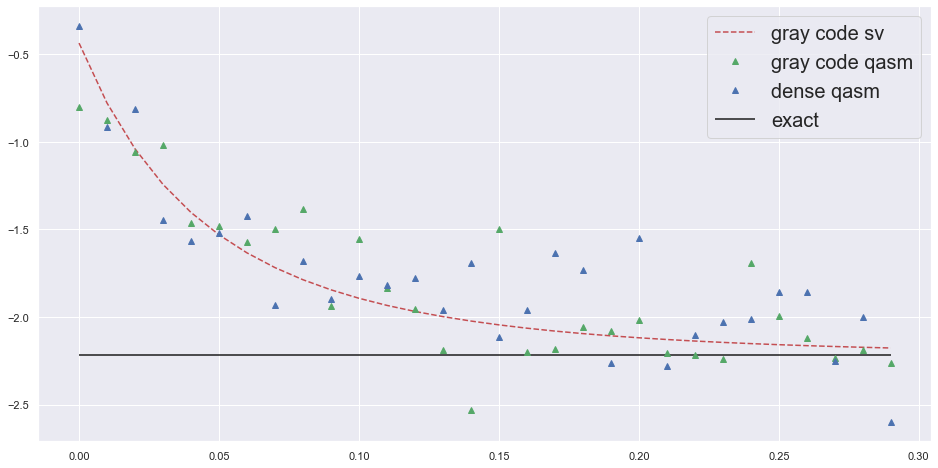

In [56]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="gray code sv")
plt.plot(time,qasm_energies_gc,'g^',label="gray code qasm")
plt.plot(time,qasm_energies_dense,'b^',label="dense qasm")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [80]:
class JordanWignerHamiltonian(EncodingHamiltonian):
    def __init__(self, H, qiskit_order=True):    
        """ Class for the Jordan-Wigner encoded Hamiltonian. 

        Parameters: 
            H (np.matrix) : Hamiltonian matrix to be encoded 
            
            qiskit_order (bool): Determines whether to order the qubits in qiskit order, i.e.
                in "reverse" as compared to the typical ordering. 
        """
        super(JordanWignerHamiltonian, self).__init__(H, qiskit_order)

        self.N_qubits=self.N_states
#         self.pauli_rep = jordan_wigner(self.ferm_rep) # In terms of Paulis; for sparse Hamiltonian just JW
#         self.relabel_qubits() # 0 index the qubits to match dense representation
        self.pauli_rep = self._build_pauli_rep()
        self.pauli_coeffs = qubit_operator_to_dict(self)
        self.pauli_partitions = self._pauli_partitions()
        self.n_partitions = len(self.pauli_partitions.keys())
        
        self.matrix = self._to_matrix() # Numerical matrix

    def _build_pauli_rep(self):
        pauli_rep=jordan_wigner(self.ferm_rep).terms.items()
        # The Jordan-Wigner transform from OpenFermion gives us Paulis where 
        # the qubits are 1-indexed. Convert to 0 indexing, and if we are using
        # Qiskit order, we also have to reverse the order of the Paulis.
        new_pauli_rep = QubitOperator()

        for pauli, coeff in pauli_rep:
            operator_string = ""
            for qubit in pauli:
                operator_string += (qubit[1] + str(qubit[0] - 1) + " ")
            new_pauli_rep += coeff.real * QubitOperator(operator_string)

        return new_pauli_rep

    
    def _to_matrix(self):
        mat = np.zeros((self.N_states, self.N_states))

        # For each term in the Hamiltonian, populate the relevant entry in the matrix
        for ferm_op in self.ferm_rep:
            dag_op, op = list(ferm_op.terms.keys())[0]
            dag_idx, op_idx = dag_op[0]-1, op[0]-1
            mat[dag_idx, op_idx] = ferm_op.terms[(dag_op, op)]

        return mat

    def _pauli_partitions(self):
        """
        Partition pauli terms in Hamiltonian into commuting sets 
        """
        pauli_dict=self.pauli_coeffs
        commuting_sets=get_commuting_sets(list(pauli_dict.keys()))

        return commuting_sets

In [81]:
Nmax=4
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 

H_jw=JordanWignerHamiltonian(H)
print(H_jw.matrix)
print(H_jw.pauli_rep)
print(H_jw.pauli_coeffs)
print(H_jw.pauli_partitions)

[[-0.43658111 -4.28660705  0.        ]
 [-4.28660705 12.25       -7.82623792]
 [ 0.         -7.82623792 19.25      ]]
15.531709445 [] +
-2.1433035249352805 [X0 X1] +
-2.1433035249352805 [Y0 Y1] +
0.21829055499999983 [Z0] +
-3.913118960624632 [X1 X2] +
-3.913118960624632 [Y1 Y2] +
-6.125 [Z1] +
-9.625 [Z2]
{'III': 15.531709445, 'IIZ': 0.21829055499999983, 'IXX': -2.1433035249352805, 'IYY': -2.1433035249352805, 'IZI': -6.125, 'XXI': -3.913118960624632, 'YYI': -3.913118960624632, 'ZII': -9.625}
{'IIZ': ['III', 'IIZ', 'IZI', 'ZII'], 'IXX': ['IXX', 'XXI'], 'IYY': ['IYY', 'YYI']}


In [82]:
sv_energies_jw,_=run_qite_experiment(H_jw,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)

100%|██████████| 30/30 [09:20<00:00, 18.69s/it]


[-2.0456709   8.56158173 24.54750806]


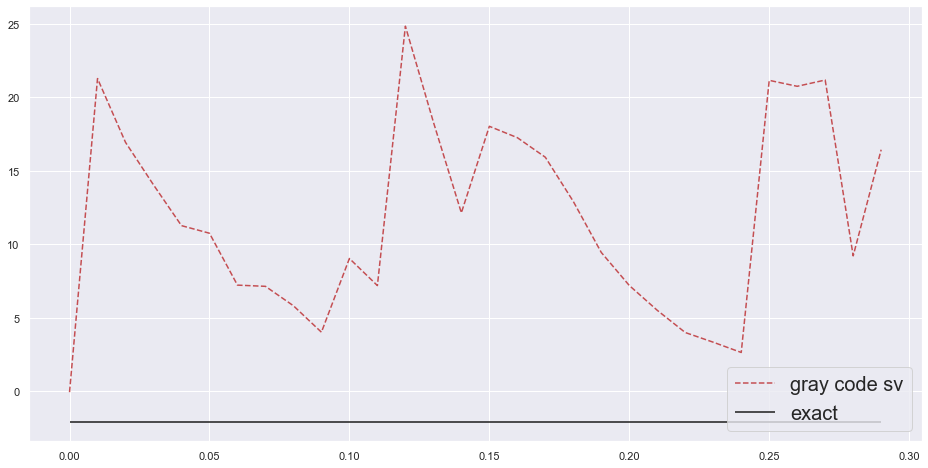

In [83]:
exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies_jw,'r--',label="gray code sv")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [84]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
n_qubits=H_jw.N_qubits
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H_graycode,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H_jw,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XXX ['III', 'IIX', 'IXI', 'IXX', 'XII', 'XIX', 'XXI', 'XXX']
XXY ['IIY', 'IXY', 'XIY', 'XXY']
XXZ ['IIZ', 'IXZ', 'XIZ', 'XXZ']
XYX ['IYI', 'IYX', 'XYI', 'XYX']
XYY ['IYY', 'XYY']
XYZ ['IYZ', 'XYZ']
XZX ['IZI', 'IZX', 'XZI', 'XZX']
XZY ['IZY', 'XZY']
XZZ ['IZZ', 'XZZ']
YXX ['YII', 'YIX', 'YXI', 'YXX']
YXY ['YIY', 'YXY']
YXZ ['YIZ', 'YXZ']
YYX ['YYI', 'YYX']
YYY ['YYY']
YYZ ['YYZ']
YZX ['YZI', 'YZX']
YZY ['YZY']
YZZ ['YZZ']
ZXX ['ZII', 'ZIX', 'ZXI', 'ZXX']
ZXY ['ZIY', 'ZXY']
ZXZ ['ZIZ', 'ZXZ']
ZYX ['ZYI', 'ZYX']
ZYY ['ZYY']
ZYZ ['ZYZ']
ZZX ['ZZI', 'ZZX']
ZZY ['ZZY']
ZZZ ['ZZZ']
